# Exploration of visualising conflict activity in Ukraine/Russia, using NASAs FIRM datasets.

WIP

To-do:

- implement animated plots
- pgeocode queried location heatmaps
- functionalise formatted heatmap

In [8]:
import geopandas
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pandas as pd
pd.options.mode.chained_assignment = None
from geodatasets import get_path
import pgeocode as pgc
import importlib
import plotly.express as px
import nbformat
import contextily as cx
import seaborn as sns
from matplotlib.gridspec import GridSpec
# create subset
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


For recent (past 10 days) data, we can make requests using NASAs API

In [3]:
import firmware as fw

We can see available data sources (different satellites/sensors) along with the date ranges available:

In [4]:
map_key = fw.get_map_key()
url = fw.get_url(map_key)
count = fw.get_transaction_count(url)

In [5]:
sources = fw.get_data_sources(map_key)

In [6]:
sources

data_id    min_date    max_date
0         MODIS_NRT  2024-07-01  2024-10-16
1          MODIS_SP  2000-11-01  2024-06-30
2  VIIRS_NOAA20_NRT  2019-12-04  2024-10-16
3  VIIRS_NOAA21_NRT  2024-01-17  2024-10-16
4    VIIRS_SNPP_NRT  2024-05-01  2024-10-16
5     VIIRS_SNPP_SP  2012-01-20  2024-04-30
6       LANDSAT_NRT  2022-06-20  2024-10-16
7          GOES_NRT  2022-08-09  2024-10-16
8          BA_MODIS  2000-11-01  2024-05-01

Lets look at the past 10 days of data from Ukraine & Russia, using the MODIS near-real-time dataset

In [9]:
past_n_days = 10
importlib.reload(fw)

<module 'firmware' from 'f:\\repos\\FirmWare\\firmware.py'>

In [10]:
gdf_rus = fw.get_country_data(map_key, "RUS", "MODIS_NRT", 10)
gdf_ukr = fw.get_country_data(map_key, "UKR", "MODIS_NRT", 10)

In [11]:
gdf = pd.concat([gdf_rus, gdf_ukr])

In [12]:
%matplotlib inline

Alternatively, we can download historic data from NASA directly, & read those dataframes

In [13]:
df_rus = pd.read_csv("data/modis_2023_Russian_Federation.csv")
df_ukr = pd.read_csv("data/modis_2023_Ukraine.csv")
df_ukr["country"] = "UKR"
df_rus["country"] = "RUS"
df = pd.concat([df_rus, df_ukr])
gdf = geopandas.GeoDataFrame(
        df,
        geometry=geopandas.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326",
    )
gdf["area"] = gdf["scan"] * gdf["track"]

Plotting all activity from this dataset as a color-coded heatmap, with different palettes for signals from either country

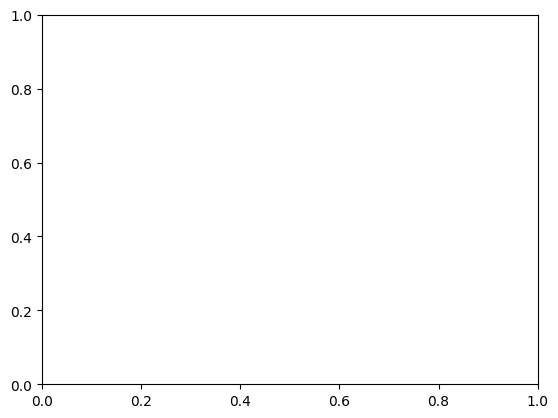

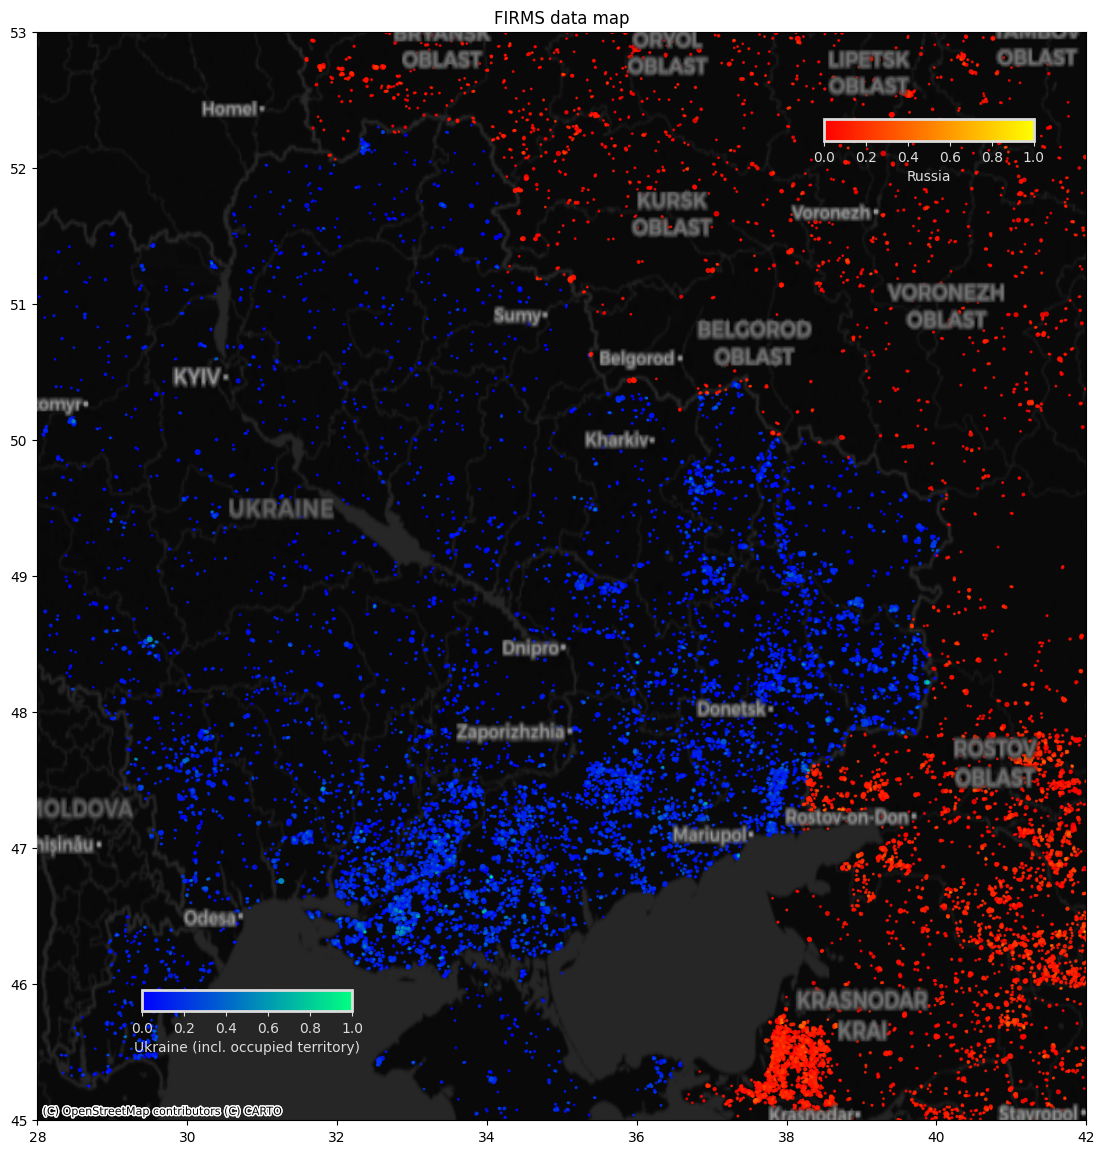

In [14]:
ax = fw.plot_gdf(gdf=gdf)

We can use matplotlibs rectangle selector to select a region of interest from these plots, & use those coordinates for further analysis

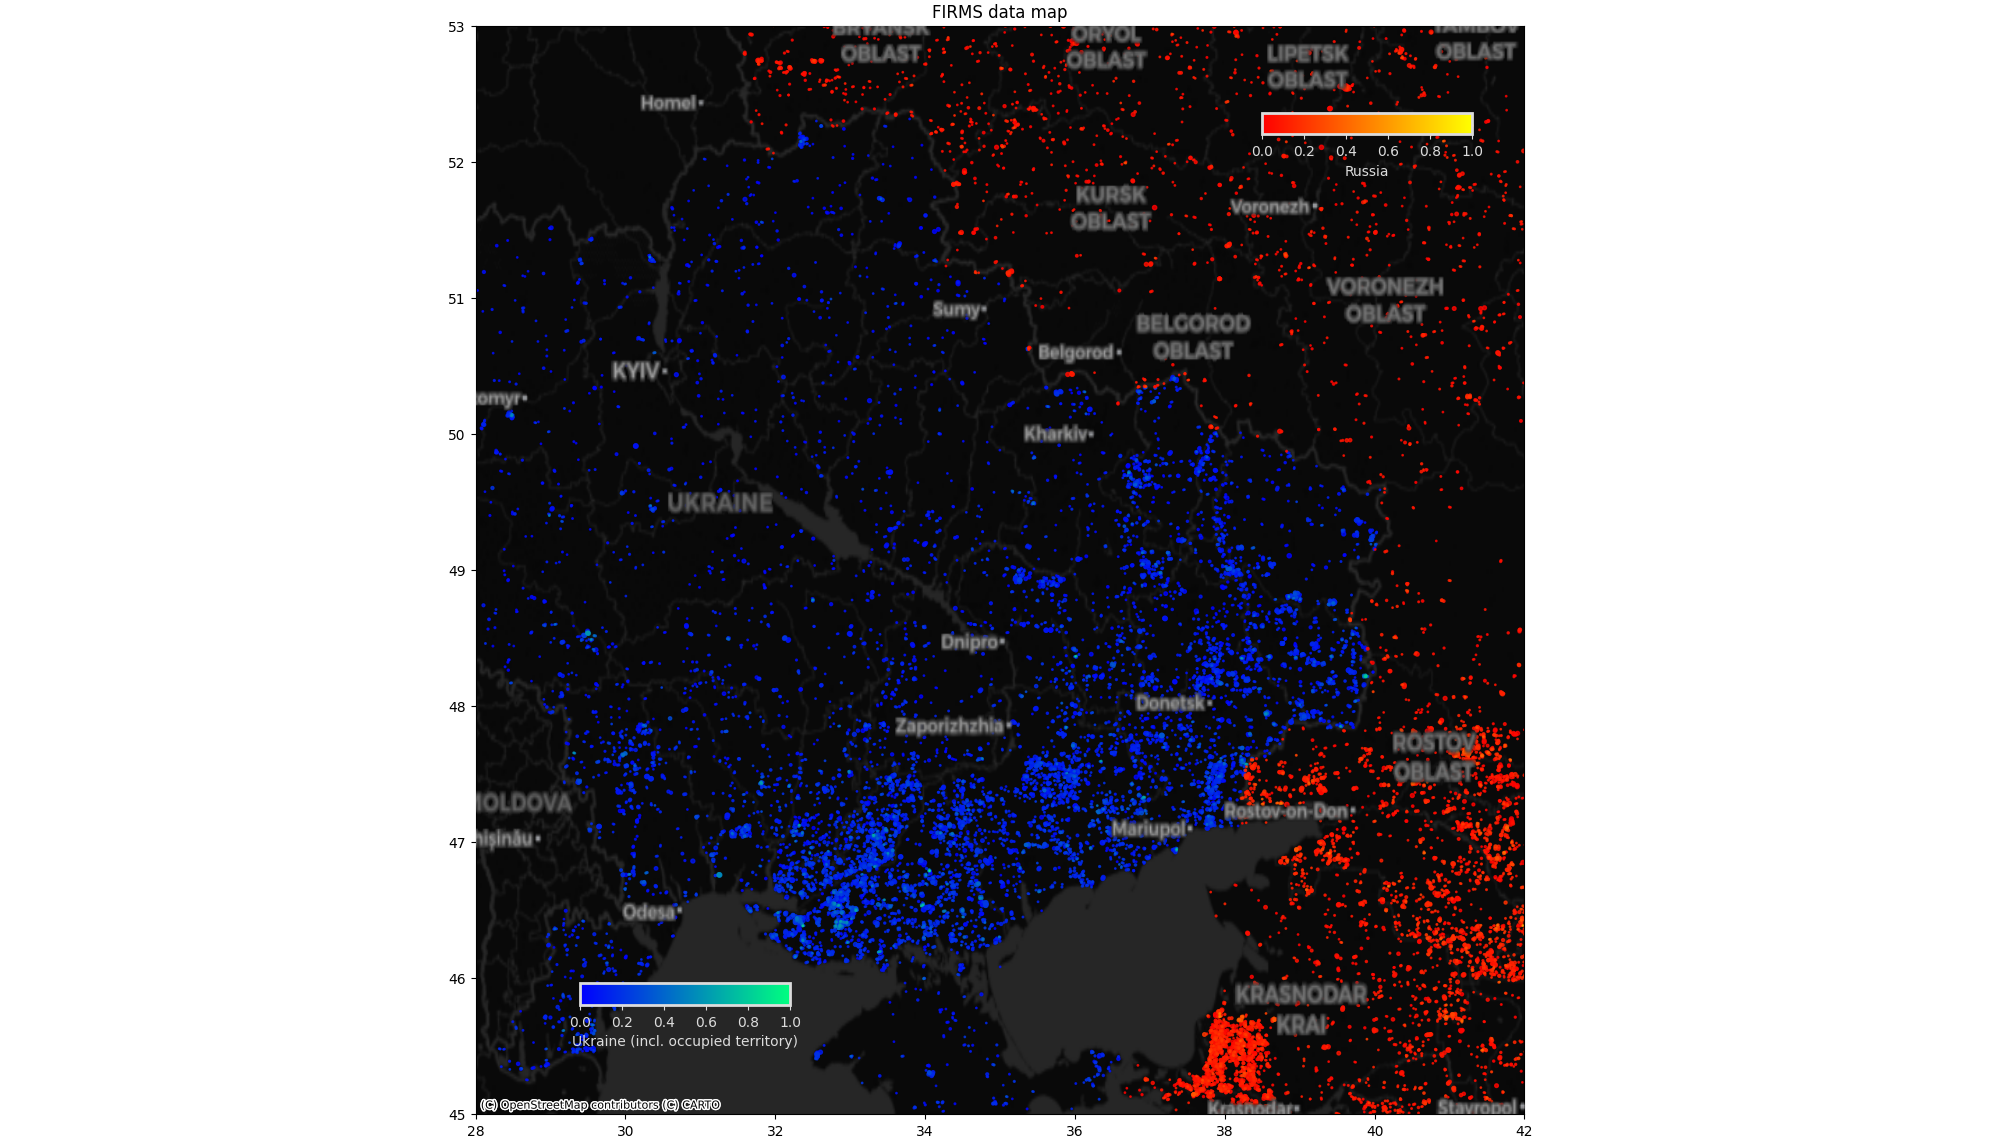

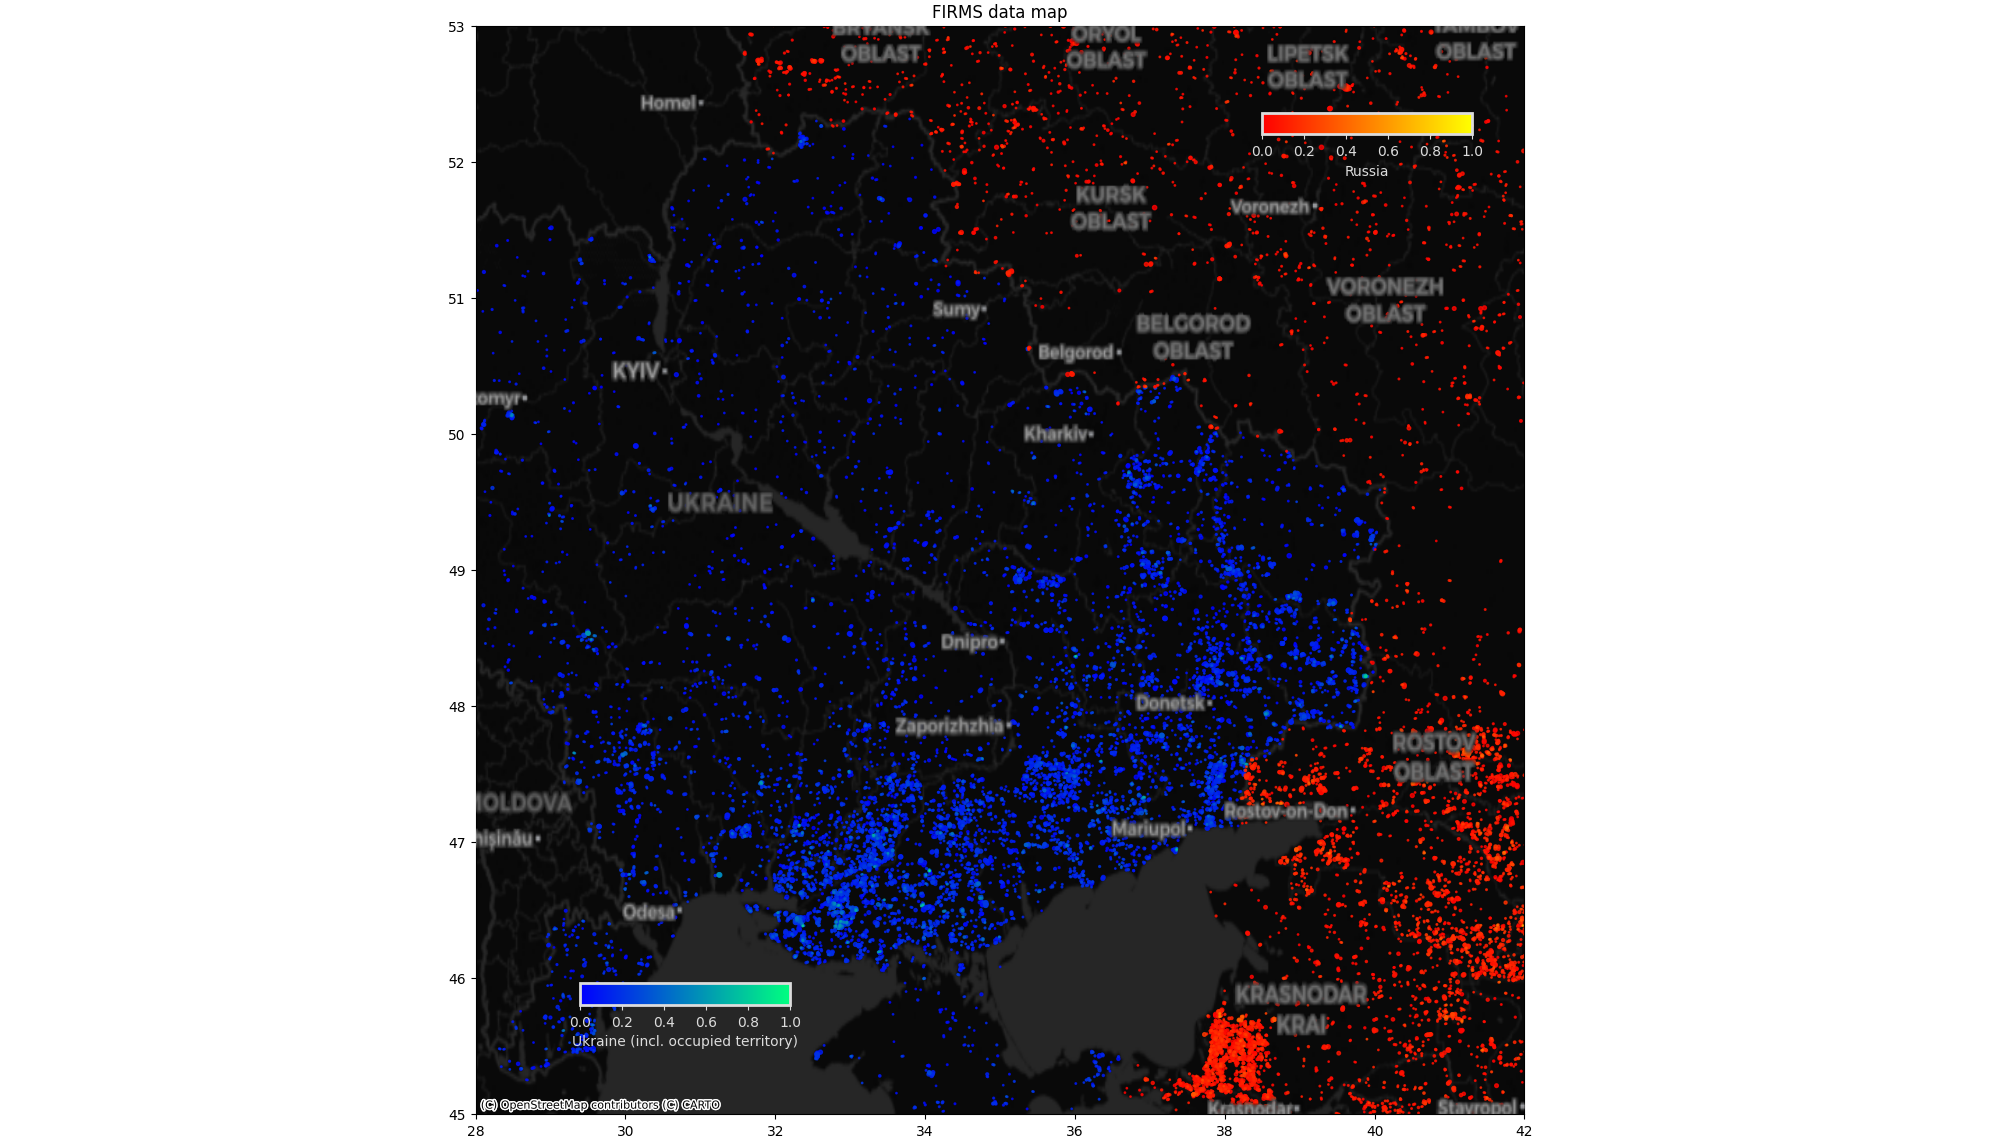

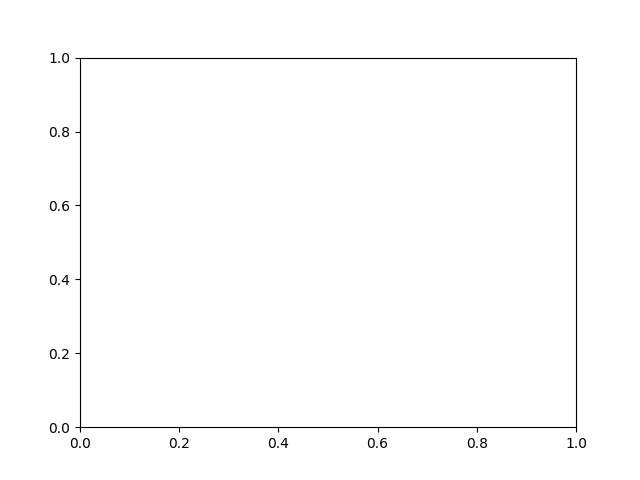

In [15]:
%matplotlib widget
ax, r_select = fw.select_plot(gdf)

In [40]:
importlib.reload(fw)

<module 'firmware' from 'f:\\repos\\FirmWare\\firmware.py'>

In [41]:
%matplotlib inline

In [42]:
def select_gps_box(gdf, bbox):
    # bbox: [x1, y1, x2, y2]
    return gdf[
        (gdf["longitude"] > bbox[0])
        & (gdf["longitude"] < bbox[1])
        & (gdf["latitude"] > bbox[2])
        & (gdf["latitude"] < bbox[3])
    ]

bbox = r_select.extents
gdf_select = fw.select_gps_box(gdf, bbox)

In [24]:
fig = fw.daily_timeseries(gdf_select)

# Using pgeocode to query specific locations by name
First we will get some longer term data (all of 2022) from NASAs dedicated download site
For historic data (as far back as 2000 depending on source) https://firms.modaps.eosdis.nasa.gov/download/create.php


In [27]:
ua_22 = pd.read_csv("data/modis/2022/modis_2022_Ukraine.csv" )
ru_22 = pd.read_csv("data/modis/2022/modis_2022_Russian_Federation.csv" )
ua_22["country"] = "UKR"
ru_22["country"]="RUS"
df = pd.concat([ua_22, ru_22])

gdf = fw.df_to_gdf(df)

In [46]:
gdf

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0       43.0975    45.0648       300.2   1.0    1.0  2023-01-01      1009   
1       56.6333   161.3270       337.1   1.2    1.1  2023-01-01      1528   
2       44.1197    42.6907       301.2   2.0    1.4  2023-01-02      1052   
3       44.3567    40.8868       312.8   1.6    1.2  2023-01-02      1052   
4       44.3876    44.6738       300.2   2.6    1.6  2023-01-02      1052   
...         ...        ...         ...   ...    ...         ...       ...   
11755   45.9491    29.0170       312.8   1.0    1.0  2023-12-27      1133   
11756   47.6278    31.1835       302.3   1.2    1.1  2023-12-27      1133   
11757   45.9474    29.0040       305.2   1.0    1.0  2023-12-27      1133   
11758   47.8592    33.4487       300.1   1.0    1.0  2023-12-31      1102   
11759   47.8782    35.1515       313.0   1.0    1.0  2023-12-31      1903   

      satellite instrument  confidence  version  bright_t31   frp daynight  \
0          Aqua      MODIS          33    61.03       280.9   6.9        D   
1          Aqua      MODIS         100    61.03       270.0   0.0        N   
2          Aqua      MODIS          45    61.03       281.1  18.4        D   
3          Aqua      MODIS          73    61.03       282.3  26.9        D   
4          Aqua      MODIS          30    61.03       286.1  19.0        D   
...         ...        ...         ...      ...         ...   ...      ...   
11755      Aqua      MODIS          73    61.03       285.5  14.0        D   
11756      Aqua      MODIS          50    61.03       275.1   9.8        D   
11757      Aqua      MODIS          61    61.03       283.9   8.6        D   
11758      Aqua      MODIS          23    61.03       279.5   7.5        D   
11759     Terra      MODIS          86    61.03       272.1  17.1        N   

       type country                 geometry  area  brightness (norm)  
0         0     RUS  POINT (45.0648 43.0975)  1.00          -1.117000  
1         1     RUS  POINT (161.327 56.6333)  1.32           0.682001  
2         0     RUS  POINT (42.6907 44.1197)  2.80          -1.068246  
3         0     RUS  POINT (40.8868 44.3567)  1.92          -0.502707  
4         0     RUS  POINT (44.6738 44.3876)  4.16          -1.117000  
...     ...     ...                      ...   ...                ...  
11755     0     UKR   POINT (29.017 45.9491)  1.00          -0.502707  
11756     0     UKR  POINT (31.1835 47.6278)  1.32          -1.014618  
11757     0     UKR   POINT (29.004 45.9474)  1.00          -0.873233  
11758     2     UKR  POINT (33.4487 47.8592)  1.00          -1.121875  
11759     2     UKR  POINT (35.1515 47.8782)  1.00          -0.492956  

[232103 rows x 19 columns]

In [29]:
search_dict = {
    "Kyiv": "Київ",
    "Kharkiv": "Харків",
    "Bakhmut": "Бахмут",
    "Mariupol": "Маріуполь",
    "Odesa": "Одеса"
}

Extracting time-series data from 'bounding boxes' surrouding these regions

In [48]:
importlib.reload(fw)
agg_df = fw.query_locations(gdf, search_dict)
fig = fw.plot_query_timeseries(agg_df)




Kyiv
lat: 48.3612
long: 35.7595
Kharkiv
lat: 49.0168
long: 30.3088
Bakhmut
lat: 48.5956
long: 37.9999
Mariupol
lat: 47.0951
long: 37.5413
Odesa
lat: 49.2671
long: 33.4136


# Animated time-lapse (WIP, not functional yet)

In [46]:
search_loc="Харків"
eng_label = "Kharkiv"
loc_df = nomi.query_location(search_loc, top_k=1, fuzzy_threshold=90)
lat = loc_df["latitude"].values[0]
long = loc_df["longitude"].values[0]

In [48]:
box_size = 50

#1km is (very) approximately 0.01 degrees of lat/long unless near the poles so for [x1, y1, x2, y2] bounding box
box = [
    lat - box_size/100,
    long - box_size/100,
    lat + box_size/100,
    long + box_size/100

]

In [49]:
def select_gps_box(gdf, bbox):
    # bbox: [x1, y1, x2, y2]
    return gdf[
        (gdf["latitude"] > bbox[0])
        & (gdf["longitude"] < bbox[1])
        & (gdf["latitude"] > bbox[2])
        & (gdf["longitude"] < bbox[3])
    ]

focus_df = select_gps_box(ua_22, box)

In [50]:
focus_df.shape

(2061, 16)

In [51]:
gdf = geopandas.GeoDataFrame(
    df_22, geometry=geopandas.points_from_xy(df_22.longitude, df_22.latitude), crs="EPSG:4326"
)
gdf["acq_date"] = pd.to_datetime(gdf["acq_date"]).dt.date
gdf["area"] = gdf["track"] * gdf["scan"]

In [52]:
%matplotlib notebook

In [53]:
def add_points(df, ax, cmap):
    df.sort_values(by="brightness (norm)", ascending=True).plot(
        ax=ax,
        column="brightness (norm)",
        zorder=1,
        cmap=cmap,
        alpha=0.8,
        markersize="area",
        legend=False,
    )

def add_cbar(ax, cmap, cbar_pos, cbar_label):
    cbaxes = ax.inset_axes(cbar_pos)
    cbar = ColorbarBase(cbaxes, cmap=cmap, orientation="horizontal")
    cbar.outline.set_color('gainsboro')
    cbar.outline.set_linewidth(2)
    cbar.set_label(cbar_label, color="gainsboro")
    cbar.ax.xaxis.set_tick_params(color="gainsboro")
    plt.setp(plt.getp(cbaxes, 'xticklabels'), color="gainsboro")
    cbar.outline.set_edgecolor("gainsboro")

def init_plot():
    mean_br = gdf["brightness"].mean()
    std_br = gdf["brightness"].std()
    gdf["brightness (norm)"] = gdf["brightness"].apply(lambda x: (x-mean_br)/ std_br)

    long_min = bounds[1]
    long_max = bounds[3]
    lat_min = bounds[0]
    lat_max = bounds[2]

    map_source = cx.providers.CartoDB.DarkMatterNoLabels

    # set our extent
    w = lat_max - lat_min
    h = long_max - long_min
    ratio = w / h

    fig, ax = plt.subplots(figsize=(20, 20/ratio), layout="constrained")
    world.plot(ax=ax, alpha=0, edgecolor=[0, 0, 0, 0])
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([long_min, long_max])
    ax.set(title=f'"Wildfires" in Russia & Ukraine, 2023')
    cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterNoLabels
    )
    add_cbar(ax=ax, cmap="winter", cbar_pos=(0.1, 0.1, 0.2, 0.02), cbar_label="Ukraine (incl. occupied territory), brightness (AU)")
    add_cbar(ax=ax, cmap="autumn", cbar_pos=(0.75, 0.90, 0.2, 0.02), cbar_label="Russia, brightness (AU)")
    cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels
    )

def anomaly_map(gdf, ax):
    add_points(gdf[gdf["country"]=="UKR"], ax=ax, cmap="winter")
    add_points(gdf[gdf["country"]=="RUS"], ax=ax, cmap="autumn")
    

In [54]:
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

bounds = [28, 45, 42, 53]

mean_br = gdf["brightness"].mean()
std_br = gdf["brightness"].std()
gdf["brightness (norm)"] = gdf["brightness"].apply(lambda x: (x-mean_br)/ std_br)

long_min = bounds[1]
long_max = bounds[3]
lat_min = bounds[0]
lat_max = bounds[2]

map_source = cx.providers.CartoDB.DarkMatterNoLabels

# set our extent
w = lat_max - lat_min
h = long_max - long_min
ratio = w / h

fig, ax = plt.subplots(figsize=(20, 20/ratio), layout="constrained")
world.plot(ax=ax, alpha=0, edgecolor=[0, 0, 0, 0])
ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])
ax.set(title=f'"Wildfires" in Russia & Ukraine, 2022')

cx.add_basemap(
        ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterNoLabels
    )
add_cbar(ax=ax, cmap="winter", cbar_pos=(0.1, 0.1, 0.2, 0.02), cbar_label="Ukraine (incl. occupied territory), brightness (AU)")
add_cbar(ax=ax, cmap="autumn", cbar_pos=(0.75, 0.90, 0.2, 0.02), cbar_label="Russia, brightness (AU)")
cx.add_basemap(
    ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels
)

def update(frame):
    frame_df = gdf[gdf["acq_date"]==frame]
    anomaly_map(frame_df, ax)
    return ax
    
df_22["acq_date"] = pd.to_datetime(df_22["acq_date"]).dt.date

dates = df_22["acq_date"].unique()

ani = animation.FuncAnimation(fig=fig, func=update, frames=dates, interval=30)
ani.save("test.gif")

ValueError: aspect must be finite and positive 

In [180]:
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>